In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [3]:
data_dir = 'C:/Users/gahuk/Deep Learning/trafic_signals'
train_path = 'C:/Users/gahuk/Deep Learning/trafic_signals/Train'

IMG_HEIGHT = 60
IMG_WIDTH = 60
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))

In [9]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [5]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 60, 60, 3) (39209,)


In [6]:
aug = ImageDataGenerator(
    brightness_range=(0.5, 1.5),
    rotation_range=15,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [7]:
augmented_image_data = []
augmented_image_labels = []

augmented_samples_per_image = 3

for i in range(len(image_data)):
    image = image_data[i]
    label = image_labels[i]
    augmented_image_data.append(image/255)
    augmented_image_labels.append(label)
    
    image = np.expand_dims(image, axis=0)

    
    for _ in range(augmented_samples_per_image):
        augmented_image = aug.flow(image, batch_size=1).next()[0]
        augmented_image_data.append(augmented_image/255)
        augmented_image_labels.append(label)

augmented_image_data = np.array(augmented_image_data)
augmented_image_labels = np.array(augmented_image_labels)

In [8]:
print(len(image_data))
print(len(image_labels))
print(len(augmented_image_data))
print(len(augmented_image_labels))

39209
39209
156836
156836


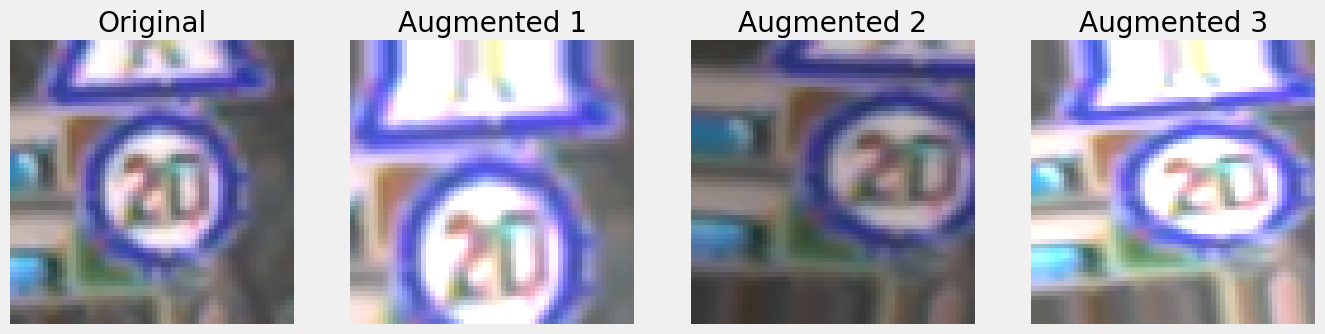

In [9]:
original_index =1

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(augmented_image_data[original_index *4])
plt.title('Original')
plt.axis('off')

for i in range(1, 4):
    plt.subplot(1, 4, i+1)
    plt.imshow(augmented_image_data[original_index * 4 + i])
    plt.title(f'Augmented {i}')
    plt.axis('off')

plt.show()

In [10]:
# indices = np.arange(len(augmented_image_data))
# np.random.shuffle(indices)
# augmented_image_data = augmented_image_data[indices]
# augmented_image_labels = augmented_image_labels[indices]

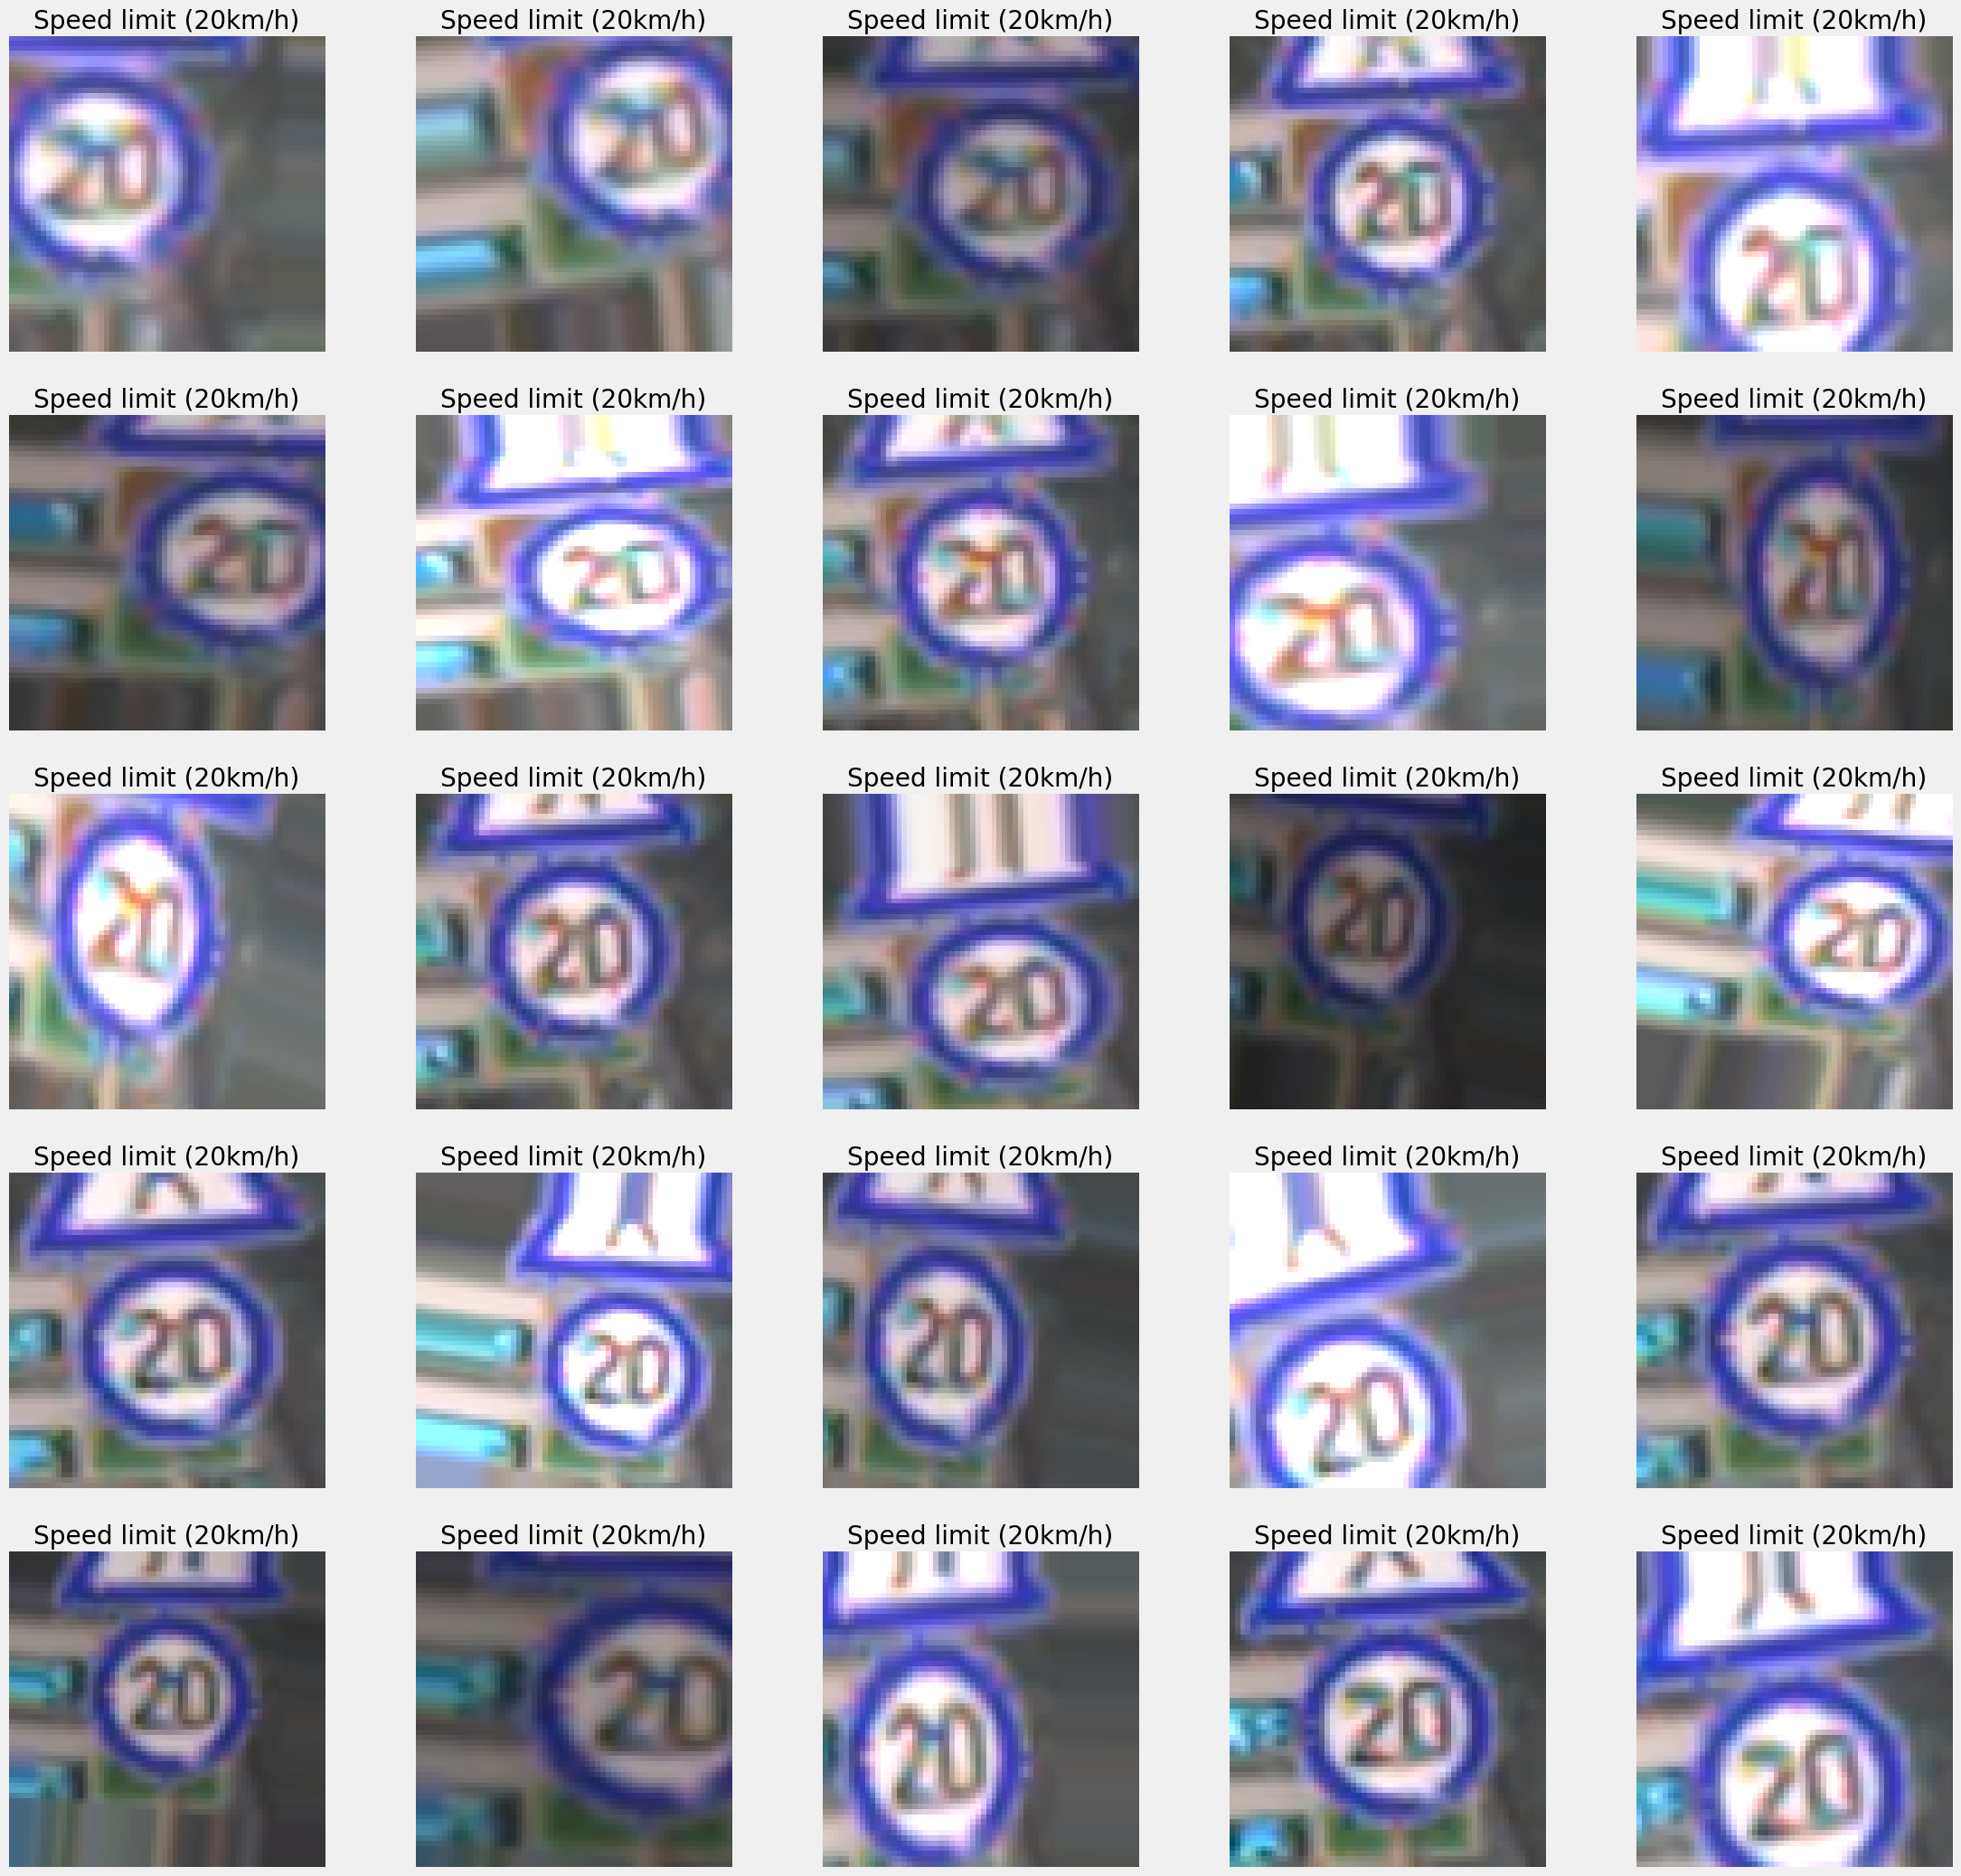

In [11]:
plt.figure(figsize=(25,25))
for i in range(1,26):
    plt.subplot(5, 5, i)
    plt.imshow(augmented_image_data[i])
    plt.title(classes[augmented_image_labels[i]])
    plt.axis('off')
plt.show()

In [12]:
print(augmented_image_data.shape)

(156836, 60, 60, 3)


In [13]:
X_train, X_val, y_train, y_val = train_test_split(augmented_image_data, augmented_image_labels, test_size=0.3, random_state=42, shuffle=True)


print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (109785, 60, 60, 3)
X_valid.shape (47051, 60, 60, 3)
y_train.shape (109785,)
y_valid.shape (47051,)


In [14]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(109785, 43)
(47051, 43)


In [15]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [16]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
history_with_aug = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
3431/3431 [==============================] - 512s 148ms/step - loss: 0.7303 - accuracy: 0.8008 - val_loss: 0.3278 - val_accuracy: 0.9087
Epoch 2/30
3431/3431 [==============================] - 509s 148ms/step - loss: 0.1115 - accuracy: 0.9671 - val_loss: 0.1112 - val_accuracy: 0.9668
Epoch 3/30
3431/3431 [==============================] - 469s 137ms/step - loss: 0.0570 - accuracy: 0.9825 - val_loss: 0.0657 - val_accuracy: 0.9801
Epoch 4/30
3431/3431 [==============================] - 469s 137ms/step - loss: 0.0370 - accuracy: 0.9885 - val_loss: 0.0634 - val_accuracy: 0.9814
Epoch 5/30
3431/3431 [==============================] - 472s 138ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.0845 - val_accuracy: 0.9759
Epoch 6/30
3431/3431 [==============================] - 473s 138ms/step - loss: 0.0191 - accuracy: 0.9937 - val_loss: 0.0394 - val_accuracy: 0.9890
Epoch 7/30
3431/3431 [==============================] - 467s 136ms/step - loss: 0.0154 - accuracy: 0.9950 - val_

In [18]:
np.save('training_history.npy', history_with_aug.history)

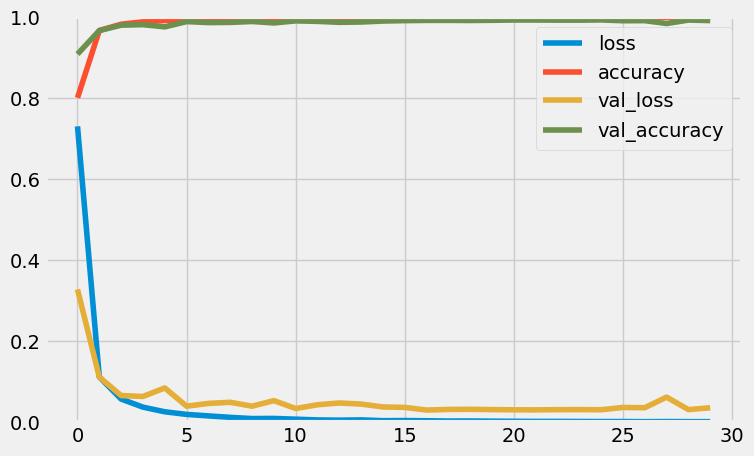

In [19]:
pd.DataFrame(history_with_aug.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [1]:
from keras.models import load_model
model = load_model('model.h5')

In [7]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred_probabilities = model.predict(X_test)
pred = np.argmax(pred_probabilities, axis=1)
print(len(pred))


print('Test Data accuracy: ', accuracy_score(labels, pred) * 100)

395/395 [==============================] - 23s 56ms/step
12630
Test Data accuracy:  98.70942201108473


<Axes: >

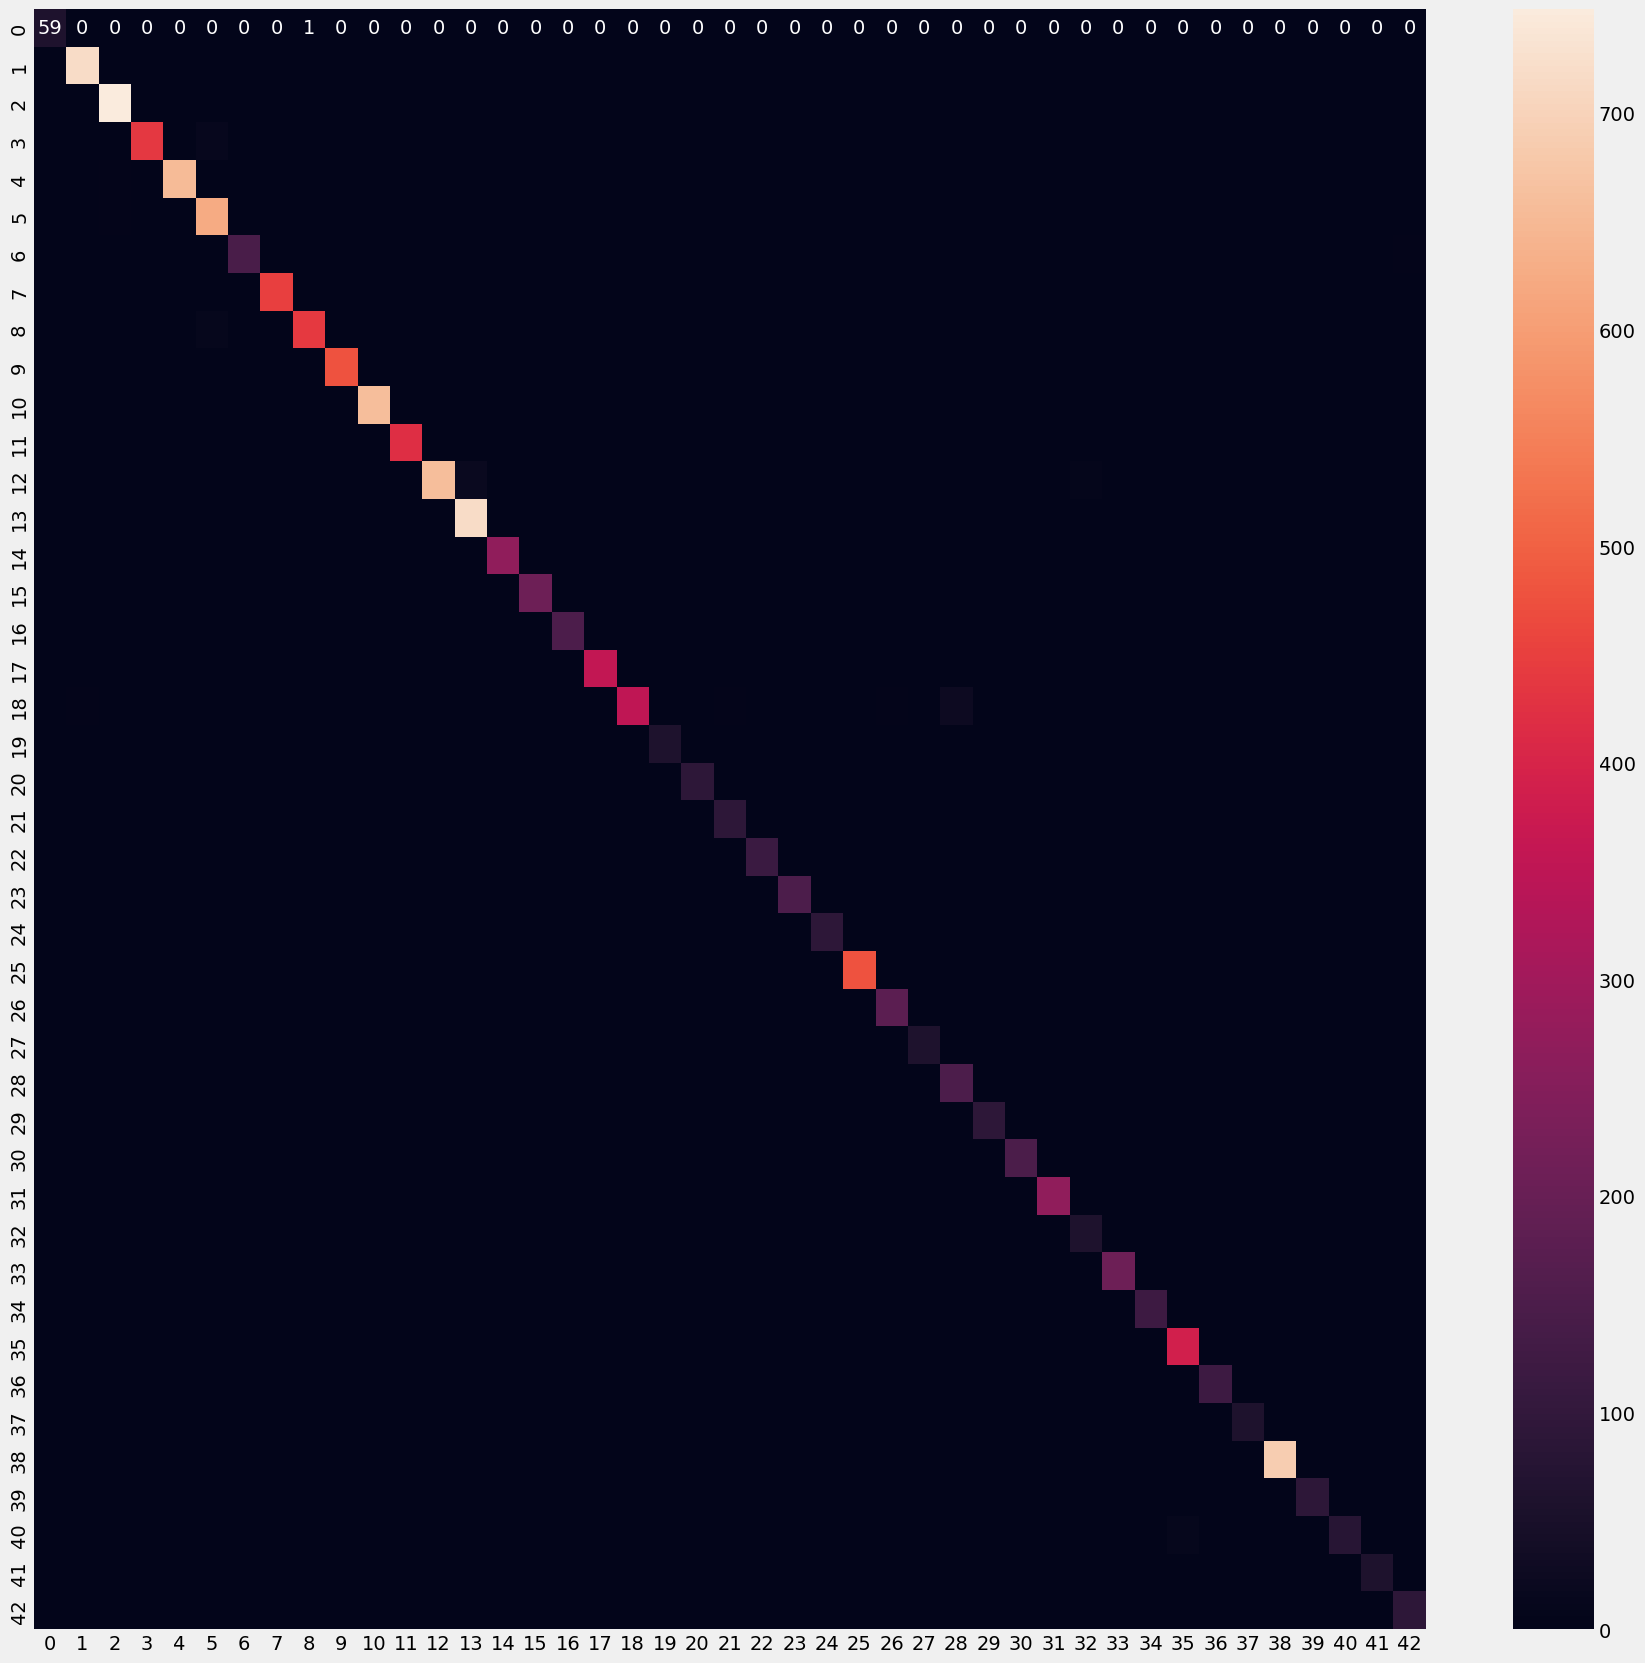

In [10]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

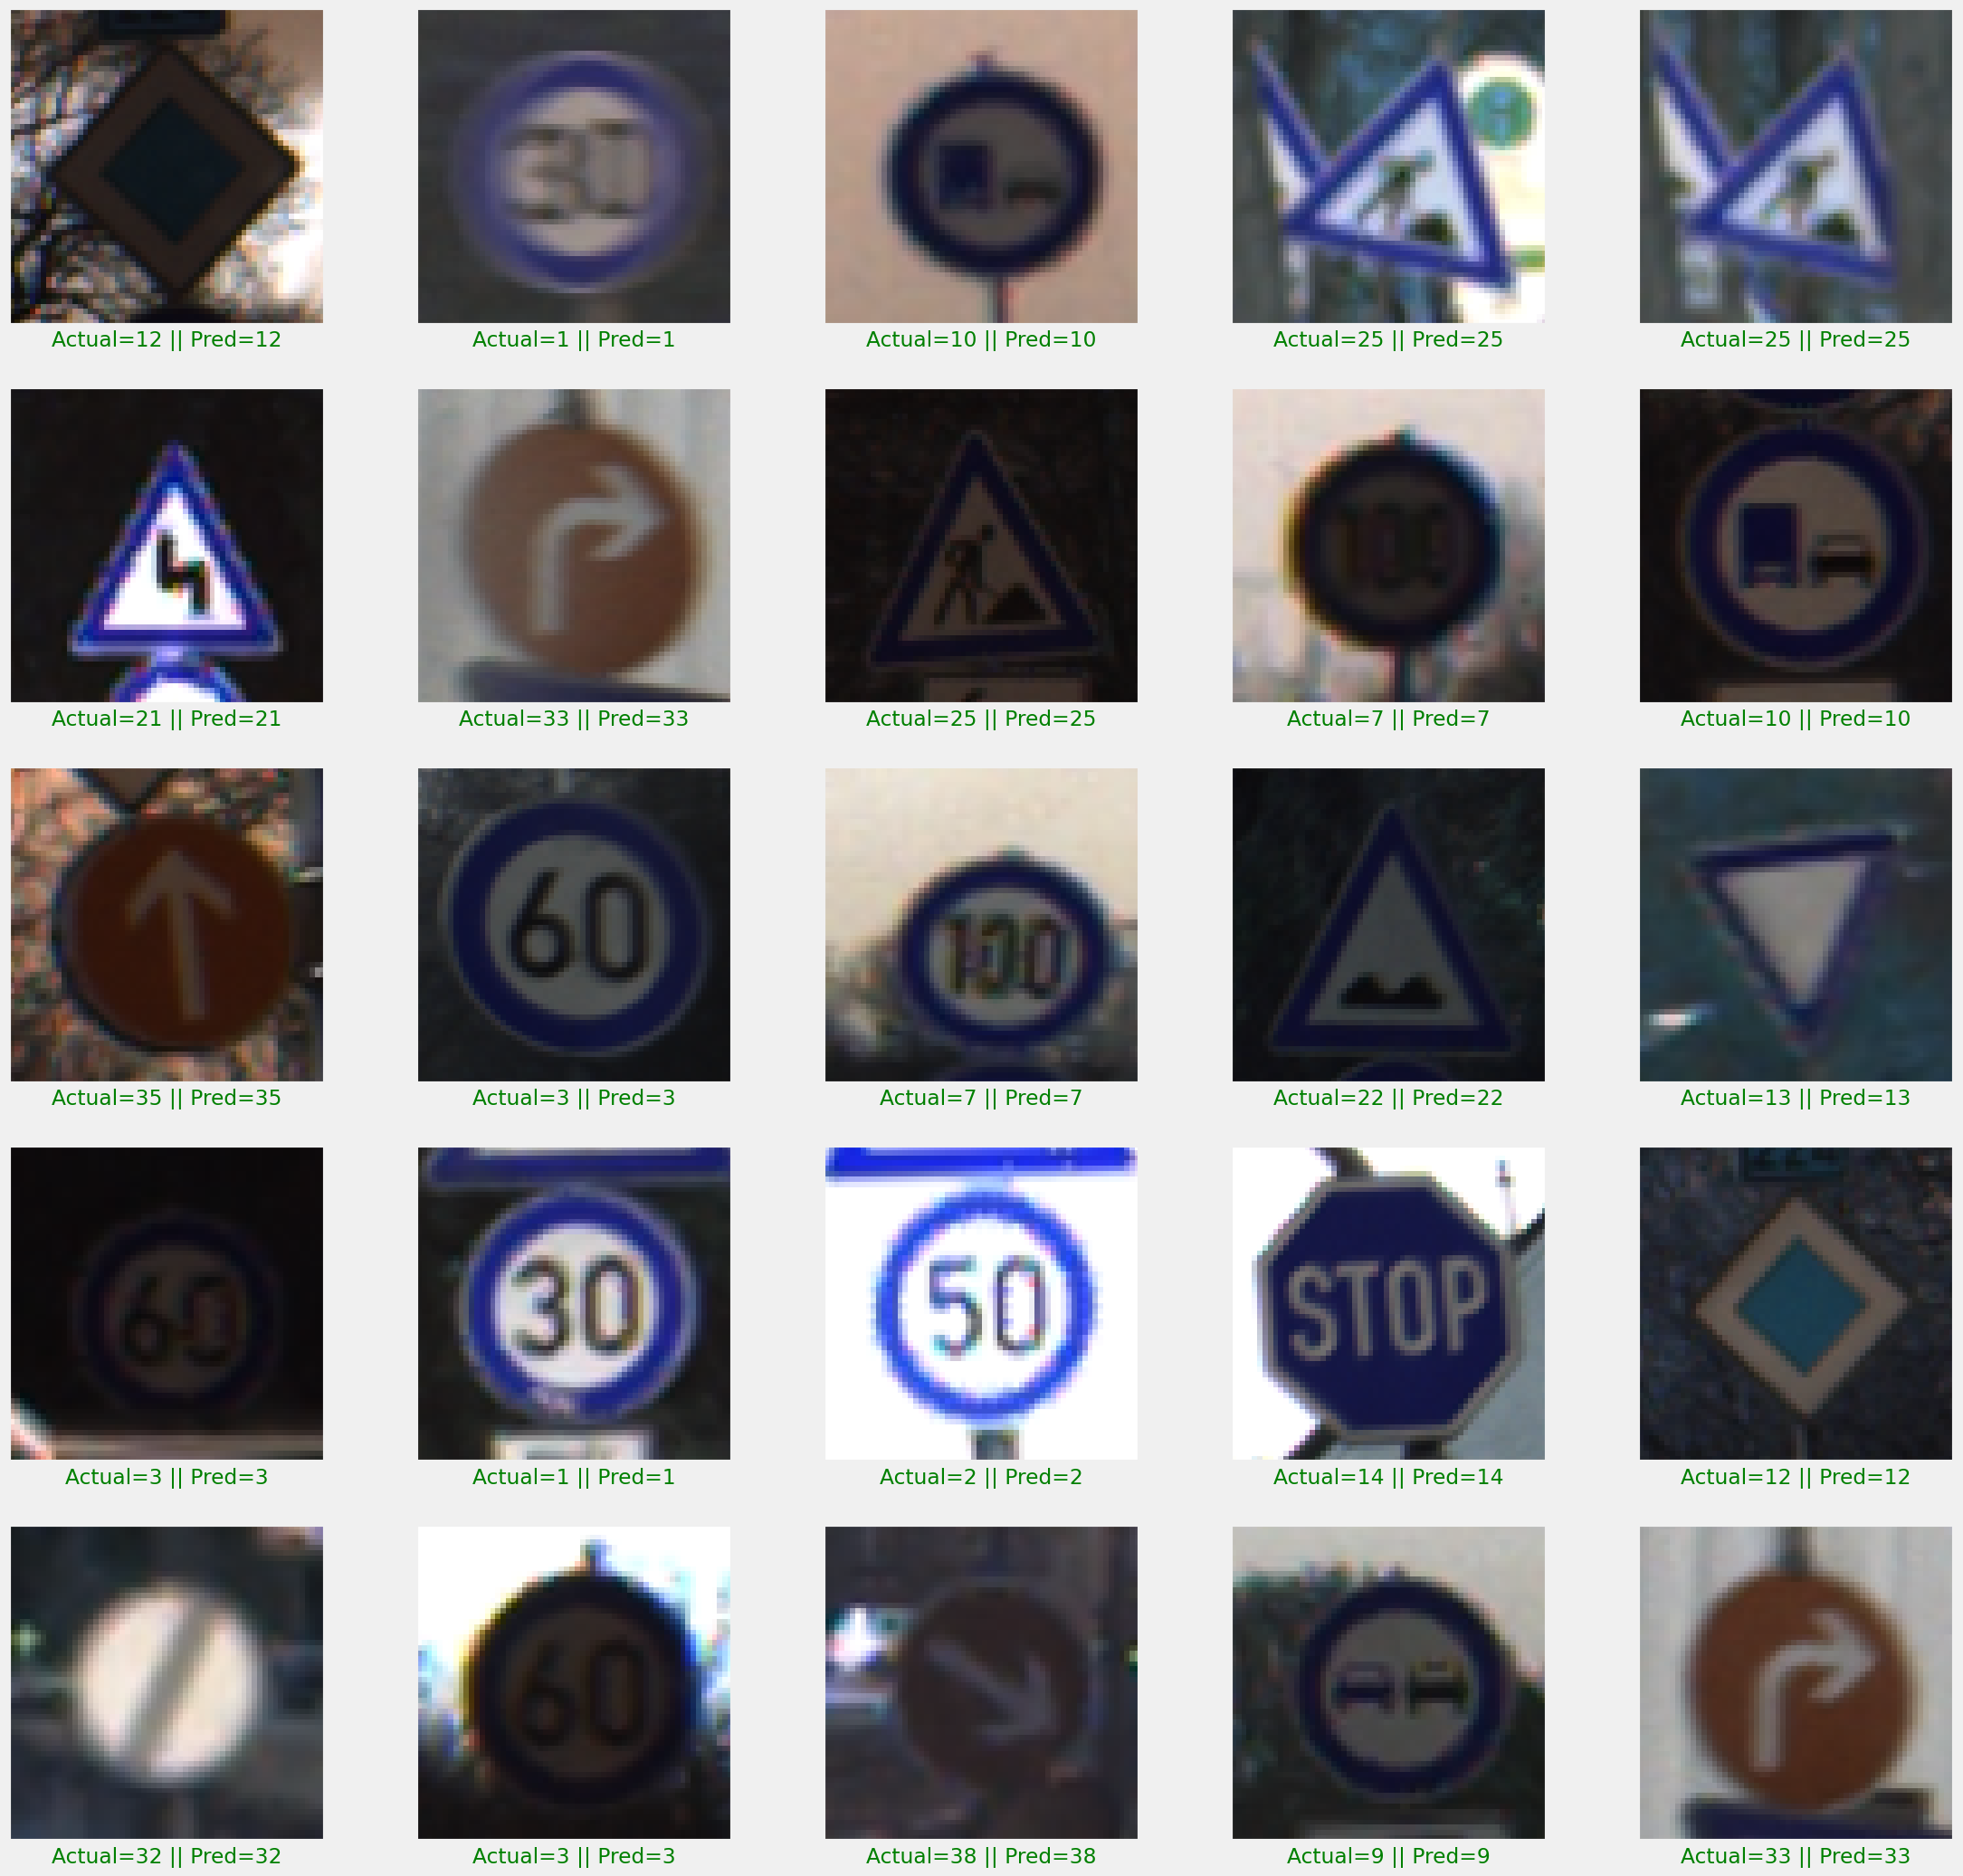

In [22]:
plt.figure(figsize = (25, 25))

start_index = 75
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [23]:
model.save('model1.h5')